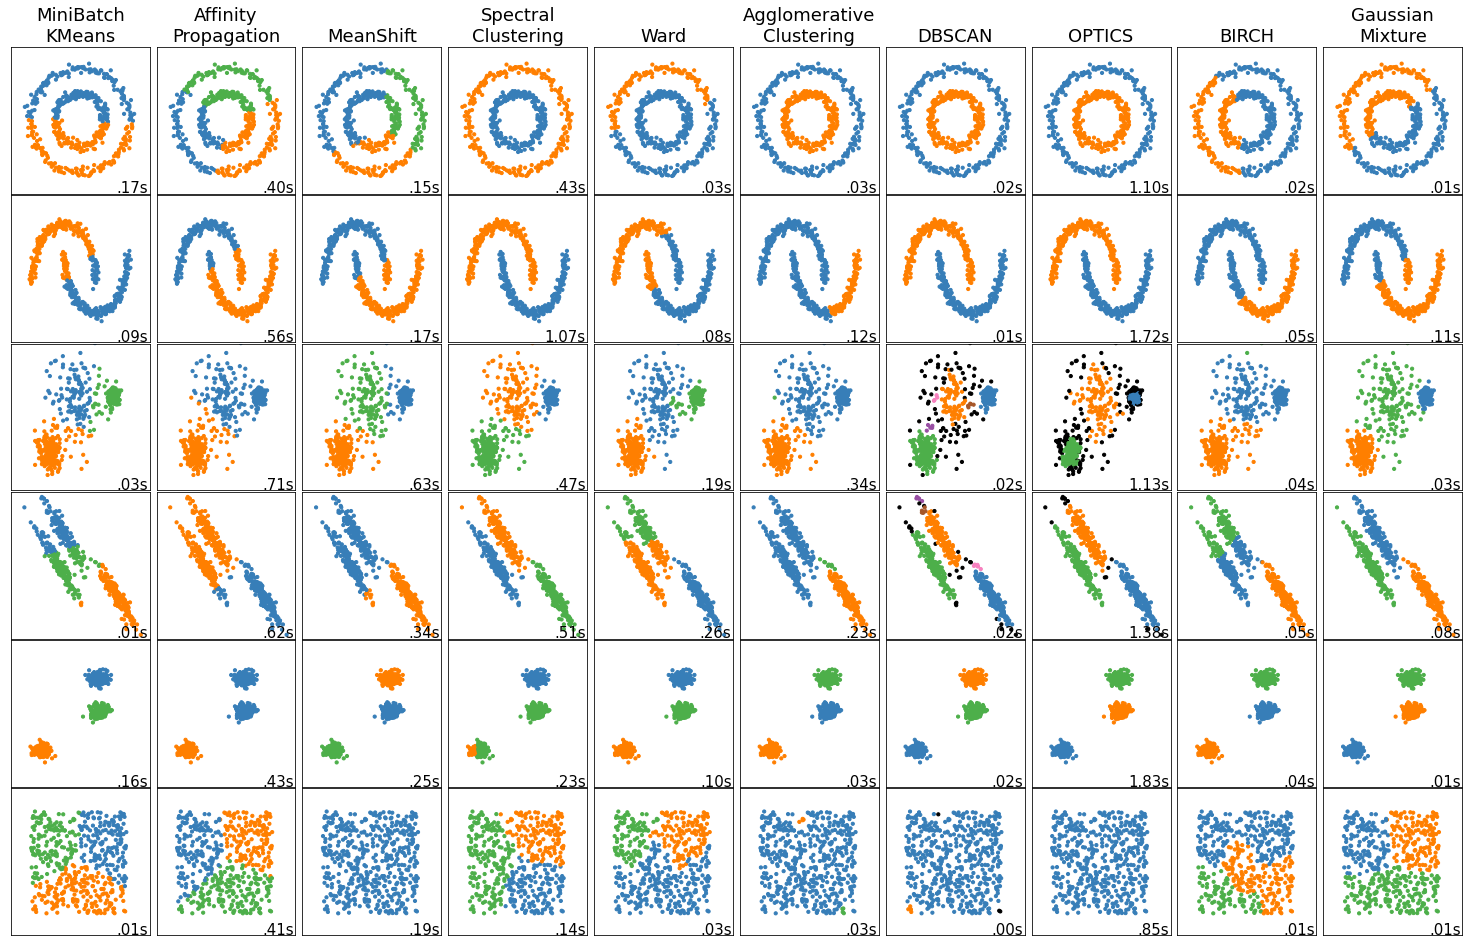

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(60000,28,28,1)
X_test  = X_test.reshape(10000,28,28,1)

new_X_Train = np.reshape(X_train,(-1,28*28))
new_X_Test = np.reshape(X_test,(-1,28*28))

class_list  = [[] for i in range(10)]
    
for i in range(len(X_train)):
    class_list[y_train[i]].append(X_train[i])


for i in range(10):
    random.shuffle(class_list[i])
    sample_X = class_list[i][:100]
    class_list[i] = sample_X

class_list = np.array(class_list)



In [52]:
from sklearn import cluster 

agglo = cluster.AgglomerativeClustering(n_clusters = 10).fit(class_list.reshape(1000,-1))
spectral = cluster.SpectralClustering(n_clusters = 10, eigen_solver = 'arpack',affinity='nearest_neighbors').fit(class_list.reshape(1000,-1))
GMM = mixture.GaussianMixture(n_components = 10, covariance_type = 'full').fit(class_list.reshape(1000,-1))
kmeans = cluster.KMeans(n_clusters = 10).fit(class_list.reshape(1000,-1))


In [82]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

temp_a = [] 
label_a = agglo.fit_predict(class_list.reshape(1000,-1))


for i in range(10):
    temp_a.append(np.bincount(label_a.reshape(10,-1)[i]).argmax())


new_list_a = []
for i in range(10):
    for j in range(100):
      new_list_a.append(temp_a[i])


score = rand_score(new_list_a, label_a)
score2 = mutual_info_score(new_list_a, label_a)
score3 = normalized_mutual_info_score(new_list_a, label_a)
print("rand_score: ",score)
print("mutual_info_score: ",score2)
print("normalized_mutual_info_score: ",score3)



rand_score:  0.8893373373373373
mutual_info_score:  1.3810659822448432
normalized_mutual_info_score:  0.6432219475045975


In [83]:
temp_s = [] 
label_s = spectral.fit_predict(class_list.reshape(1000,-1))

for i in range(10):
    temp_s.append(np.bincount(label_s.reshape(10,-1)[i]).argmax())

new_list_s = []
for i in range(10):
    for j in range(100):
      new_list_s.append(temp_s[i])


score = rand_score(new_list_s, label_s)
score2 = mutual_info_score(new_list_s, label_s)
score3 = normalized_mutual_info_score(new_list_s, label_s)
print("rand_score: ",score)
print("mutual_info_score: ",score2)
print("normalized_mutual_info_score: ",score3)

rand_score:  0.8753693693693694
mutual_info_score:  1.2417560181051674
normalized_mutual_info_score:  0.6256403779104138


In [84]:
temp_g = [] 
label_g = GMM.fit_predict(class_list.reshape(1000,-1))

for i in range(10):
    temp_g.append(np.bincount(label_g.reshape(10,-1)[i]).argmax())

new_list_g = []
for i in range(10):
    for j in range(100):
      new_list_g.append(temp_g[i])


score = rand_score(new_list_g, label_g)
score2 = mutual_info_score(new_list_g, label_g)
score3 = normalized_mutual_info_score(new_list_g, label_g)
print("rand_score: ",score)
print("mutual_info_score: ",score2)
print("normalized_mutual_info_score: ",score3)

rand_score:  0.8666806806806807
mutual_info_score:  1.018635660780017
normalized_mutual_info_score:  0.47637057051509507


In [85]:
temp_k = [] 
label_k = kmeans.fit_predict(class_list.reshape(1000,-1))


for i in range(10):
    temp_k.append(np.bincount(label_k.reshape(10,-1)[i]).argmax())

new_list_k = []
for i in range(10):
    for j in range(100):
      new_list_k.append(temp_k[i])


score = rand_score(new_list_k, label_k)
score2 = mutual_info_score(new_list_k, label_k)
score3 = normalized_mutual_info_score(new_list_k, label_k)

print("rand_score: ",score)
print("mutual_info_score: ",score2)
print("normalized_mutual_info_score: ",score3)

rand_score:  0.8622042042042042
mutual_info_score:  1.0716688762945468
normalized_mutual_info_score:  0.50071421447699


In [87]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

num_predict = [[] for i in range(10)]
center_list = []

for i in range(1000):
  for j in range(10):
    if label_k[i] == j: 
      num_predict[j].append(i) 

x_value = []
label = [] 

for i in range(10):
  center_list.append(num_predict[i][len(num_predict[i])//2])

for i in range(10):
  label.append(center_list[i]//100)

for i in range(10):
  x_value.append(class_list.reshape(1000,-1)[center_list[i]])


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_value,label)
prediction = knn.predict(new_X_Test)
score = classification_report(y_test,prediction)
print(score)

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       980
           1       0.51      0.89      0.65      1135
           2       0.40      0.36      0.38      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.41      0.42      0.41       892
           6       0.42      0.86      0.56       958
           7       0.34      0.88      0.49      1028
           8       0.43      0.35      0.39       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.45     10000
   macro avg       0.34      0.44      0.36     10000
weighted avg       0.34      0.45      0.36     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
num_predict = [[] for i in range(10)]
center_list = []

for i in range(1000):
  for j in range(10):
    if label_a[i] == j: 
      num_predict[j].append(i) 

x_value = []
label = [] 

for i in range(10):
  center_list.append(num_predict[i][len(num_predict[i])//2])

for i in range(10):
  label.append(center_list[i]//100)

for i in range(10):
  x_value.append(class_list.reshape(1000,-1)[center_list[i]])



knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_value,label)
prediction = knn.predict(new_X_Test)
score = classification_report(y_test,prediction)
print(score)



              precision    recall  f1-score   support

           0       0.86      0.53      0.66       980
           1       0.41      0.49      0.45      1135
           2       0.73      0.15      0.25      1032
           3       0.31      0.79      0.44      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.75      0.59      0.66       958
           7       0.25      0.86      0.39      1028
           8       0.51      0.50      0.51       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.40     10000
   macro avg       0.38      0.39      0.34     10000
weighted avg       0.38      0.40      0.34     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
num_predict = [[] for i in range(10)]
center_list = []

for i in range(1000):
  for j in range(10):
    if label_s[i] == j: 
      num_predict[j].append(i) 

x_value = []
label = [] 

for i in range(10):
  center_list.append(num_predict[i][len(num_predict[i])//2])

for i in range(10):
  label.append(center_list[i]//100)

for i in range(10):
  x_value.append(class_list.reshape(1000,-1)[center_list[i]])



knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_value,label)
prediction = knn.predict(new_X_Test)
score = classification_report(y_test,prediction)
print(score)

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       980
           1       0.36      0.94      0.52      1135
           2       0.72      0.38      0.49      1032
           3       0.00      0.00      0.00      1010
           4       0.34      0.43      0.38       982
           5       0.36      0.51      0.42       892
           6       0.68      0.65      0.66       958
           7       0.51      0.48      0.49      1028
           8       0.35      0.41      0.38       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.46     10000
   macro avg       0.41      0.45      0.41     10000
weighted avg       0.40      0.46      0.41     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
num_predict = [[] for i in range(10)]
center_list = []

for i in range(1000):
  for j in range(10):
    if label_g[i] == j: 
      num_predict[j].append(i) 

x_value = []
label = [] 

for i in range(10):
  center_list.append(num_predict[i][len(num_predict[i])//2])

for i in range(10):
  label.append(center_list[i]//100)

for i in range(10):
  x_value.append(class_list.reshape(1000,-1)[center_list[i]])



knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_value,label)
prediction = knn.predict(new_X_Test)
score = classification_report(y_test,prediction)
print(score)

              precision    recall  f1-score   support

           0       0.60      0.77      0.67       980
           1       0.43      0.90      0.58      1135
           2       0.00      0.00      0.00      1032
           3       0.54      0.19      0.28      1010
           4       0.00      0.00      0.00       982
           5       0.39      0.28      0.32       892
           6       0.63      0.73      0.68       958
           7       0.63      0.66      0.64      1028
           8       0.37      0.36      0.36       974
           9       0.26      0.59      0.36      1009

    accuracy                           0.45     10000
   macro avg       0.39      0.45      0.39     10000
weighted avg       0.38      0.45      0.39     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
